### Load dataset

In [1]:
import os
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists
from os import makedirs

In [2]:
run_name = "verysmall_balanced_cyclical_decay"
wandb.init(project="binary_search_optimization", name=run_name)

W&B Run: https://app.wandb.ai/panuthep/binary_search_optimization/runs/56oueg6q

In [3]:
DATASET_DIR = "./datasets/dataset_verysmall_balanced.pkl"
WEIGHTS_DIR = join("./save_weights", run_name)
if not exists(WEIGHTS_DIR):
    makedirs(WEIGHTS_DIR)

MAX_MONSTER_NUM = 1000
MONSTER_HPS_COL = ["monster_hp_" + str(num) for num in range(1, MAX_MONSTER_NUM + 1)]
FEATURES_COL = ["focus_damage", "aoe_damage", *MONSTER_HPS_COL]
TARGET_COL = ["attack_num"]

In [4]:
dataset = pd.read_pickle(DATASET_DIR)

# Log data distribution
for col in ["focus_damage", "aoe_damage", "attack_num"]:
    plt.hist(dataset[col])
    wandb.log({col: plt})

/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



### Train test split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
bins = np.linspace(dataset[TARGET_COL].to_numpy().min(), dataset[TARGET_COL].to_numpy().max(), 100, dtype=int)
Y_bin = np.digitize(dataset[TARGET_COL].to_numpy(), bins)

try:
    train_set, test_set = train_test_split(dataset, random_state=42, shuffle=True, stratify=Y_bin)
except:
    train_set, test_set = train_test_split(dataset, random_state=42, shuffle=True)

X_train, Y_train = train_set[FEATURES_COL].to_numpy(), train_set[TARGET_COL].to_numpy()
X_test, Y_test = test_set[FEATURES_COL].to_numpy(), test_set[TARGET_COL].to_numpy()

In [7]:
len(X_train), len(X_test)

(68250, 22750)

### Normalization

In [8]:
import joblib
from sklearn.preprocessing import MinMaxScaler

In [9]:
X_scaler = MinMaxScaler() if not exists(join(WEIGHTS_DIR, "X_scaler.pkl")) else joblib.load(join(WEIGHTS_DIR, "X_scaler.pkl"))
X_train_scaled = X_scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = X_scaler.transform(X_test.astype(np.float32))

Y_scaler = MinMaxScaler() if not exists(join(WEIGHTS_DIR, "Y_scaler.pkl")) else joblib.load(join(WEIGHTS_DIR, "Y_scaler.pkl"))
Y_train_scaled = Y_scaler.fit_transform(Y_train.astype(np.float32))
Y_test_scaled = Y_scaler.transform(Y_test.astype(np.float32))

In [10]:
# Save parameters for scalers
joblib.dump(X_scaler, join(WEIGHTS_DIR, "X_scaler.pkl"))
joblib.dump(Y_scaler, join(WEIGHTS_DIR, "Y_scaler.pkl"))

['./save_weights/verysmall_balanced_cyclical_decay/Y_scaler.pkl']

### Model

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.callbacks import LearningRateScheduler
from utilities import LearningRateFinder, Cosine

In [12]:
wandb.config.network_depth = 1
wandb.config.network_width = 16
wandb.config.activation = "LeakyReLU"
wandb.config.optimizer = "Adam"
wandb.config.loss = "MAE"
wandb.config.stepsize = 20
wandb.config.epochs = 160
wandb.config.batch_size = 32
wandb.config.validation_split = 0.2

In [13]:
class SequenceDense(Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = []
        for _ in range(wandb.config.network_depth):
            self.hidden_layers.append(Dense(wandb.config.network_width, activation=LeakyReLU()))
        self.output_layer = Dense(1, activation="relu")
        
    def call(self, inputs):
        output = inputs
        for layer in self.hidden_layers:
            output = layer(output)
        output = self.output_layer(output)
        
        return output

Train on 68250 samples
Epoch 1/20
68250/68250 [==============================] - 3s 41us/sample - loss: 0.4318
Epoch 2/20
68250/68250 [==============================] - 2s 33us/sample - loss: 0.4318
Epoch 3/20
68250/68250 [==============================] - 2s 34us/sample - loss: 0.4314
Epoch 4/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.4293
Epoch 5/20
68250/68250 [==============================] - 3s 39us/sample - loss: 0.4215
Epoch 6/20
68250/68250 [==============================] - 3s 38us/sample - loss: 0.3728
Epoch 7/20
68250/68250 [==============================] - 3s 41us/sample - loss: 0.2043
Epoch 8/20
68250/68250 [==============================] - 3s 37us/sample - loss: 0.1815
Epoch 9/20
68250/68250 [==============================] - 3s 37us/sample - loss: 0.1720
Epoch 10/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.1570
Epoch 11/20
68250/68250 [==============================] - 2s 35us/sample - loss: 0.1341
Epoch 1

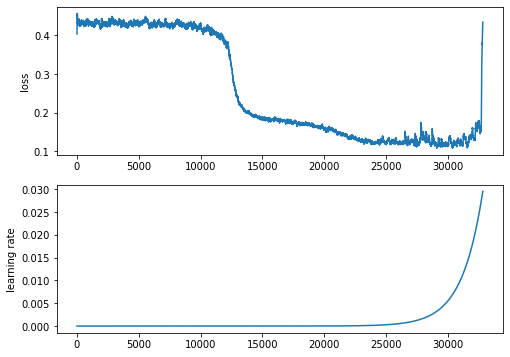

In [14]:
model_name = "model_{}_{}".format(wandb.config.network_depth, wandb.config.network_width)

model = SequenceDense()
model.build(input_shape=X_train_scaled.shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")
try:
    model.load_weights(join("./save_weights", model_name))
except:
    model.save_weights(join("./save_weights", model_name))

lr_finder = LearningRateFinder(model)
lr_finder.find((X_train_scaled, Y_train_scaled), start_lr=1e-10, epochs=20)
lr_finder.plot()

In [15]:
plt.plot(lr_finder.losses)
wandb.log({"lr_finder": plt})

/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



In [16]:
base_lr = lr_finder.lrs[15000]
max_lr = lr_finder.lrs[30000]
wandb.log({"learning_rate_base": base_lr})
wandb.log({"learning_rate_max": max_lr})
wandb.log({"learning_rate_base_index": 15000})
wandb.log({"learning_rate_max_index": 30000})

Train on 54600 samples, validate on 13650 samples
Epoch 1/160
54600/54600 [==============================] - 2s 39us/sample - loss: 0.2419 - val_loss: 0.1839
Epoch 2/160
54600/54600 [==============================] - 2s 31us/sample - loss: 0.1587 - val_loss: 0.1409
Epoch 3/160
54600/54600 [==============================] - 2s 32us/sample - loss: 0.1317 - val_loss: 0.1223
Epoch 4/160
54600/54600 [==============================] - 2s 32us/sample - loss: 0.1229 - val_loss: 0.1109
Epoch 5/160
54600/54600 [==============================] - 2s 32us/sample - loss: 0.1199 - val_loss: 0.1523
Epoch 6/160
54600/54600 [==============================] - 2s 31us/sample - loss: 0.1124 - val_loss: 0.0853
Epoch 7/160
54600/54600 [==============================] - 2s 33us/sample - loss: 0.1124 - val_loss: 0.0840
Epoch 8/160
54600/54600 [==============================] - 2s 32us/sample - loss: 0.1008 - val_loss: 0.0866
Epoch 9/160
54600/54600 [==============================] - 2s 32us/sample - loss: 0.09

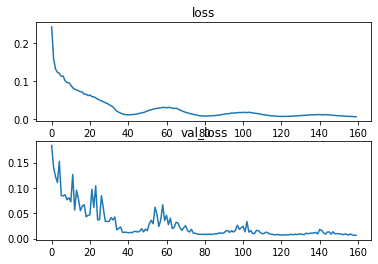

In [17]:
def history_plot(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.subplot(2, 1, 1)
    plt.title("loss")
    plt.plot(loss)
    plt.subplot(2, 1, 2)
    plt.title("val_loss")
    plt.plot(val_loss)
    
lr_cosine = Cosine(max_lr, base_lr, wandb.config.stepsize, decline_mode="half")
callbacks = [LearningRateScheduler(lr_cosine)]

model = SequenceDense()
model.build(input_shape=X_train_scaled.shape)
model.compile(optimizer=Adam(learning_rate=base_lr), loss="mae")
model.load_weights(join("./save_weights", model_name))
history = model.fit(X_train_scaled, Y_train_scaled, 
                    epochs=wandb.config.epochs, 
                    batch_size=wandb.config.batch_size, 
                    validation_split=wandb.config.validation_split, 
                    verbose=1,
                    callbacks=callbacks)
model.save_weights(join(WEIGHTS_DIR, "model_trained", model_name))

history_plot(history)

In [18]:
loss = history.history["loss"]
plt.title("train_loss")
plt.plot(loss)
wandb.log({"train_loss": plt})

val_loss = history.history["val_loss"]
plt.title("val_loss")
plt.plot(val_loss)
wandb.log({"val_loss": plt})

test_loss = model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)
wandb.log({"test_loss": test_loss})

lr_history = [lr_cosine(epoch) for epoch in range(1, 161)]
plt.title("learning_rate_history")
plt.plot(lr_history)
wandb.log({"test_loss": plt})

/anaconda3/envs/dev/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



Average loss: 0.006277257110923529


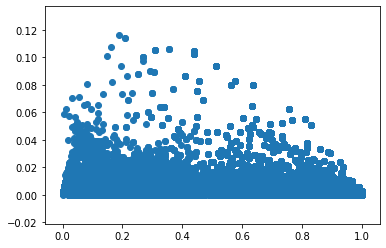

In [19]:
pred = model.predict(X_train_scaled)
loss = MAE(Y_train_scaled, pred)
plt.scatter(Y_train_scaled, loss)
wandb.log({"loss_dist": wandb.Image(plt, caption="loss_dist")})
print("Average loss: {}".format(np.mean(loss.numpy())))